# Data Preprocessing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.special import erfinv
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
from sklearn import svm
from sklearn.preprocessing import normalize
import copy
from pandas._libs.tslibs.timedeltas import parse_timedelta_unit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from statistics import mean
from numpy import std
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from sklearn.metrics import r2_score

In [2]:
df= pd.read_csv('./brazil_deforestration_by_state_formatted.csv')

In [3]:
df.head()

,Unnamed: 0,index,year,areakm,municipality,geocode_ibge,deforestation_increment(areakm),state,gdp,gdp_per_capita
0,0,0,2008,1029.568595,Acrelandia,1200013,23.667087,Acre,88512.133,7384.01
1,1,1,2009,1042.506828,Acrelandia,1200013,12.938233,Acre,94179.964,7693.81
2,2,2,2010,1053.838906,Acrelandia,1200013,11.332078,Acre,121914.728,9723.62
3,3,3,2011,1069.777544,Acrelandia,1200013,15.938638,Acre,142760.793,11171.52
4,4,4,2012,1073.942261,Acrelandia,1200013,4.164718,Acre,162198.825,12466.28


In [4]:
municipallities = df['municipality'].unique()
years = range(2008,2021)

model = LinearRegression()

#Imputing gdp using linear regression
for mun in municipallities:
  data = df.loc[df['municipality']==mun, 'gdp']
  x = np.array(years)
  y = np.array(data[0:13])
  model.fit(x.reshape(-1,1), y)
  df.loc[(df['year']==2021) & (df['municipality']==mun), 'gdp'] = model.predict([[2021]])[0]
  df.loc[(df['year']==2022) & (df['municipality']==mun), 'gdp'] = model.predict([[2022]])[0]

#Imputing gdp_per_capita using linear regression
for mun in municipallities:
  data = df.loc[df['municipality']==mun, 'gdp_per_capita']
  x = np.array(years)
  y = np.array(data[0:13])
  model.fit(x.reshape(-1,1), y)
  df.loc[(df['year']==2021) & (df['municipality']==mun), 'gdp_per_capita'] = model.predict([[2021]])[0]
  df.loc[(df['year']==2022) & (df['municipality']==mun), 'gdp_per_capita'] = model.predict([[2022]])[0]

# Multistate Model Work

In [5]:
df.drop(['Unnamed: 0', 'index', 'geocode_ibge', 'gdp'], axis= 1, inplace= True)
df.loc[:, 'state'].unique()
states= df.loc[:, 'state'].unique()
year_list= df.loc[:, 'year'].unique()

In [6]:
def create_totals_dict(first, second):
    total_dict= dict()
    for i in df_dict:
        state_df= df_dict[i]
        state_totals= []
        for j in range(len(year_list)):
            year_rows= state_df[state_df['year']==year_list[j]]
            state_totals.append([year_list[j], year_rows[first].sum(), year_rows[second].sum()])
        total_dict[i] = state_totals
    return total_dict.copy()

def generate_fitted_models(X, y):
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2)
    
    gbr = GradientBoostingRegressor()
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_val_score(gbr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    gbr.fit(X_train, y_train)
    print('GBR MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    xgbr = XGBRegressor(objective='reg:squarederror')
    n_scores = cross_val_score(xgbr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    xgbr.fit(X_train, y_train)
    print('XGBR MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    regr = RandomForestRegressor(max_depth=2, random_state=0)
    n_scores = cross_val_score(regr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    regr.fit(X_train, y_train)
    print('RegR MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    
    return [gbr, xgbr, regr]

def normalize_col(dataset, column):
    temp_arr= []
    for row in range(len(dataset)):
        temp_arr.append(dataset[row][column])
    
    norm_arr= normalize([temp_arr])
    for row in range(len(dataset)):
        dataset[row][column]= norm_arr[0][row]
        
    return dataset
    
    
def normalize_state_data(state_data):
    for i in range(3):
        state_data= normalize_col(state_data, i)

def normalize_data(state_dict):
    for state in state_dict:
        normalize_state_data(state_dict[state])
        
def plot_states(data, col):
    for i in data:
        temp= pd.DataFrame(data[i], columns= ['year', 'gdp_per_capita', 'deforestation_increment(areakm)'])
        plt.plot(year_list, temp.loc[:, col], label= i)
        
    plt.legend(loc="upper left")
    plt.show()
    
def create_model_dict(data):
    models_area= dict()
    for i in data:
        temp= pd.DataFrame(data[i], columns= ['year', 'gdp_per_capita', 'deforestation_increment(areakm)'])
        print(i)
        models_area[i]= generate_fitted_models(temp.iloc[:, :-1], temp.iloc[:, -1])
        print()
    
    return models_area.copy()

def test_models(state_models, data):
    data= pd.DataFrame(data, columns= ['year', 'gdp_per_capita', 'deforestation_increment(areakm)'])
    predictions0= state_models[0].predict(data.iloc[:, :-1])
    predictions1= state_models[1].predict(data.iloc[:, :-1])
    predictions2= state_models[2].predict(data.iloc[:, :-1])
    average= (predictions0 + predictions1 + predictions2) / 3
    
    print("GBR MSE")
    print(mse(data.iloc[:, 2], predictions0))
    print("XGBR MSE")
    print(mse(data.iloc[:, 2], predictions1))
    print("RegR MSE")
    print(mse(data.iloc[:, 2], predictions2))
    print("Average MSE")
    print(mse(data.iloc[:, 2], average))
    
    plt.plot(year_list, predictions0, label="GBR")
    plt.plot(year_list, predictions1, label="XGBR")
    plt.plot(year_list, predictions2, label="RegR")
    plt.plot(year_list, average, label= 'average')
    plt.plot(year_list, data.iloc[:, 2], label="Actual")
    plt.legend(loc="upper left")
    plt.show()

In [7]:
df_dict= dict()
for i in range(len(states)):
    df_dict[states[i]]= df[df['state']==states[i]]
    
df_dict['Acre'].head()

,year,areakm,municipality,deforestation_increment(areakm),state,gdp_per_capita
0,2008,1029.568595,Acrelandia,23.667087,Acre,7384.01
1,2009,1042.506828,Acrelandia,12.938233,Acre,7693.81
2,2010,1053.838906,Acrelandia,11.332078,Acre,9723.62
3,2011,1069.777544,Acrelandia,15.938638,Acre,11171.52
4,2012,1073.942261,Acrelandia,4.164718,Acre,12466.28


In [8]:
totals_gdpfirst= create_totals_dict('gdp_per_capita', 'deforestation_increment(areakm)')
totals_gdpfirst

{'Acre': [[2008, 145914.47999999998, 288.758773115],
  [2009, 160315.14999999997, 161.73121515],
  [2010, 183570.99, 265.263014167],
  [2011, 194469.08, 295.551357035],
  [2012, 214874.25000000003, 270.513846939],
  [2013, 251921.53000000003, 200.24381298400004],
  [2014, 276941.99, 348.58877788099994],
  [2015, 283534.11, 222.85491036500002],
  [2016, 301327.03, 366.165799929],
  [2017, 307036.71, 245.65356542800004],
  [2018, 304631.31, 426.58599921600006],
  [2019, 303250.32999999996, 706.879518306],
  [2020, 316961.6099999999, 660.7160176330001],
  [2021, 356035.31269230763, 892.054821032],
  [2022, 371240.9225274727, 950.7140687460001]],
 'Amapa': [[2008, 143337.85, 99.91568042099999],
  [2009, 148793.28, 47.459032799],
  [2010, 162177.90000000002, 72.238348701],
  [2011, 186025.97, 16.615481320999997],
  [2012, 208945.27, 19.449449491],
  [2013, 239165.26, 24.236671939],
  [2014, 236234.26, 29.120926611999998],
  [2015, 256628.44, 19.109309711],
  [2016, 269291.57999999996, 12.41

In [9]:
totals_gdpfirst_norm= create_totals_dict('gdp_per_capita', 'deforestation_increment(areakm)')
normalize_data(totals_gdpfirst_norm)
totals_gdpfirst_norm

{'Acre': [[0.2573013294355532, 0.1378695447914874, 0.15295702125967314],
  [0.2574294675478219, 0.1514762397376807, 0.08566986432027568],
  [0.2575576056600906, 0.173449878505702, 0.1405111957626583],
  [0.2576857437723593, 0.1837471067684259, 0.15655508822696068],
  [0.257813881884628, 0.2030272460616127, 0.14329258914258491],
  [0.2579420199968967, 0.23803193942283893, 0.1060701873376974],
  [0.2580701581091654, 0.26167290658849385, 0.1846492854019466],
  [0.25819829622143414, 0.26790157274699206, 0.11804740300980018],
  [0.25832643433370284, 0.28471348737610463, 0.19395992523489453],
  [0.25845457244597153, 0.2901083665032828, 0.13012396895979625],
  [0.2585827105582402, 0.2878355872490138, 0.2259648184790378],
  [0.2587108486705089, 0.2865307470168028, 0.37443775073285135],
  [0.2588389867827776, 0.29948606119884025, 0.34998470476063814],
  [0.2589671248950463, 0.3364054512655861, 0.47252606995613267],
  [0.25909526300731506, 0.35077270601817245, 0.503598178009776]],
 'Amapa': [[0.

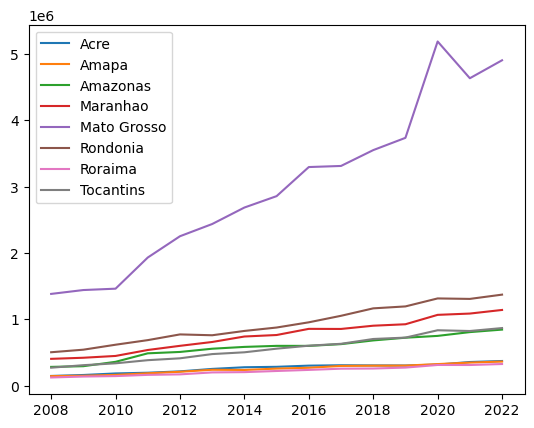

In [10]:
plot_states(totals_gdpfirst, 'gdp_per_capita')

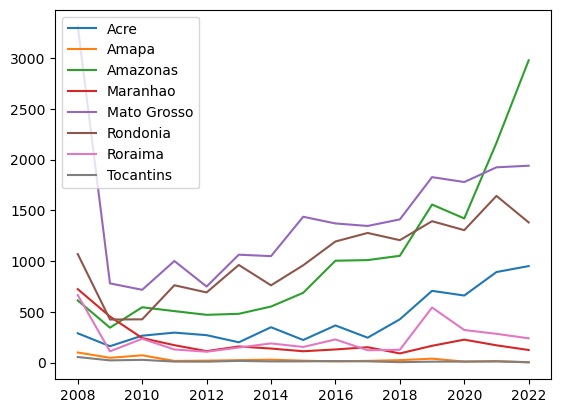

In [11]:
plot_states(totals_gdpfirst, 'deforestation_increment(areakm)')

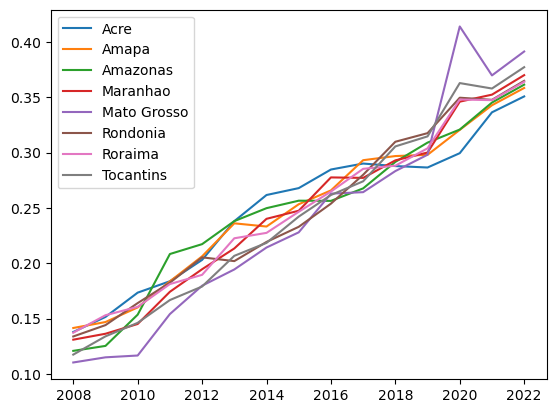

In [12]:
plot_states(totals_gdpfirst_norm, 'gdp_per_capita')

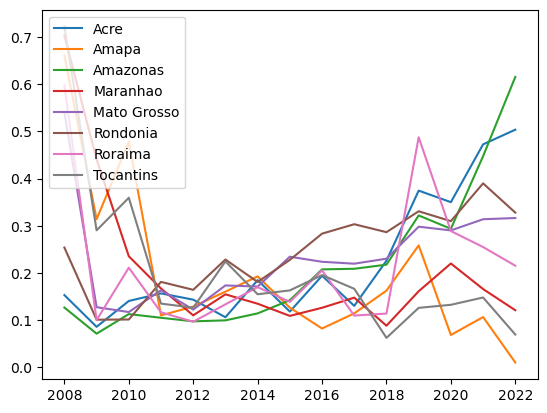

In [13]:
plot_states(totals_gdpfirst_norm, 'deforestation_increment(areakm)')

In [14]:
models_gdp= create_model_dict(totals_gdpfirst)

Acre
GBR MAE: -100.505 (38.134)
XGBR MAE: -114.468 (46.392)
RegR MAE: -88.907 (48.035)

Amapa
GBR MAE: -14.992 (6.479)
XGBR MAE: -16.294 (7.117)
RegR MAE: -15.301 (5.268)

Amazonas
GBR MAE: -221.331 (119.048)
XGBR MAE: -270.847 (160.509)
RegR MAE: -219.447 (138.736)

Maranhao
GBR MAE: -89.669 (69.647)
XGBR MAE: -82.515 (68.215)
RegR MAE: -87.319 (75.898)

Mato Grosso
GBR MAE: -333.235 (338.643)
XGBR MAE: -295.805 (324.264)
RegR MAE: -353.126 (290.741)

Rondonia
GBR MAE: -232.223 (66.608)
XGBR MAE: -213.365 (66.824)
RegR MAE: -192.238 (65.717)

Roraima
GBR MAE: -115.908 (77.657)
XGBR MAE: -117.374 (62.687)
RegR MAE: -110.045 (66.261)

Tocantins
GBR MAE: -6.563 (3.895)
XGBR MAE: -6.962 (3.742)
RegR MAE: -6.127 (3.865)



In [15]:
models_gdpnorm= create_model_dict(totals_gdpfirst_norm)

Acre
GBR MAE: -0.051 (0.019)
XGBR MAE: -0.059 (0.022)
RegR MAE: -0.042 (0.023)

Amapa
GBR MAE: -0.093 (0.048)
XGBR MAE: -0.101 (0.043)
RegR MAE: -0.098 (0.035)

Amazonas
GBR MAE: -0.052 (0.026)
XGBR MAE: -0.052 (0.027)
RegR MAE: -0.050 (0.027)

Maranhao
GBR MAE: -0.081 (0.066)
XGBR MAE: -0.089 (0.065)
RegR MAE: -0.083 (0.076)

Mato Grosso
GBR MAE: -0.047 (0.052)
XGBR MAE: -0.046 (0.053)
RegR MAE: -0.055 (0.047)

Rondonia
GBR MAE: -0.049 (0.014)
XGBR MAE: -0.042 (0.018)
RegR MAE: -0.044 (0.015)

Roraima
GBR MAE: -0.093 (0.056)
XGBR MAE: -0.112 (0.060)
RegR MAE: -0.096 (0.056)

Tocantins
GBR MAE: -0.080 (0.055)
XGBR MAE: -0.079 (0.051)
RegR MAE: -0.078 (0.052)



GBR MSE
2138.3382259169625
XGBR MSE
2878.034870455025
RegR MSE
4087.9001288417103
Average MSE
2428.0221416489935


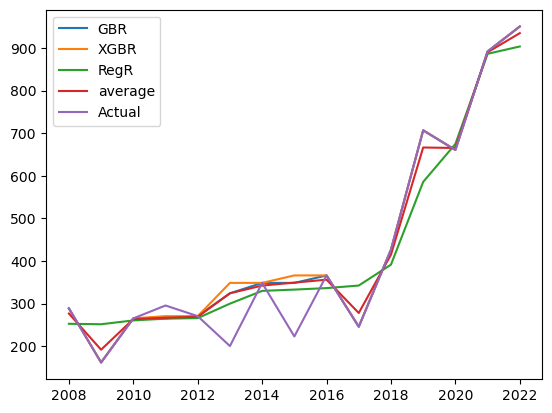

GBR MSE
49.829707893164816
XGBR MSE
55.602380864115744
RegR MSE
121.13565130951181
Average MSE
53.40652313456912


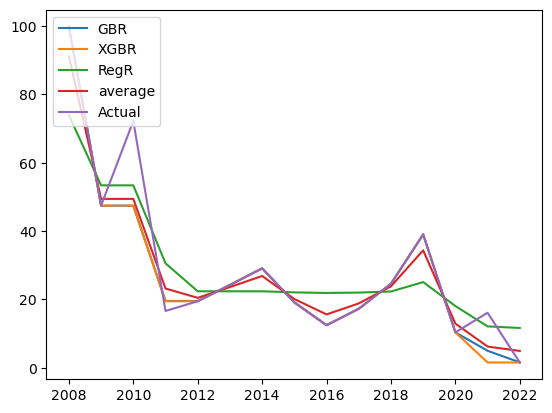

GBR MSE
198700.20716940903
XGBR MSE
198867.45606381304
RegR MSE
186347.368776621
Average MSE
193660.8025890706


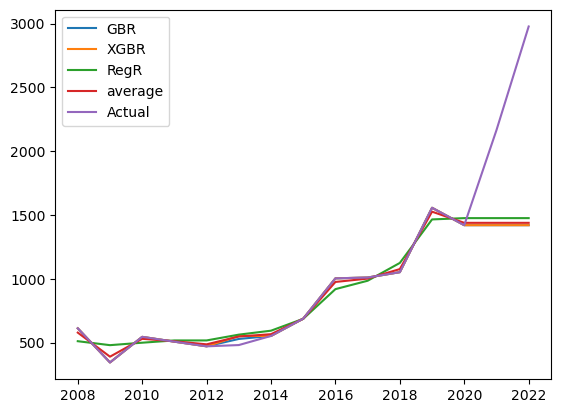

GBR MSE
589.5321052697894
XGBR MSE
812.138221849489
RegR MSE
2729.27974365504
Average MSE
796.9327656241351


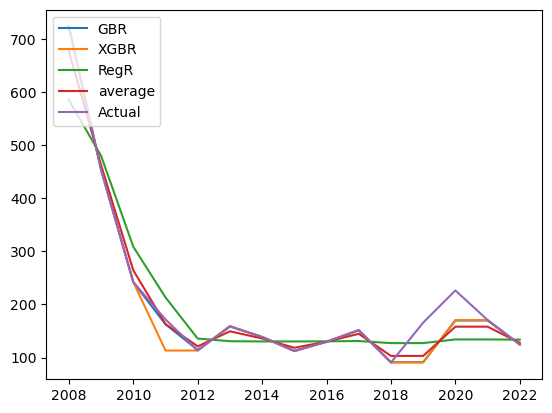

GBR MSE
4992.80000870624
XGBR MSE
5632.641758470476
RegR MSE
94907.62846923458
Average MSE
13919.357158443436


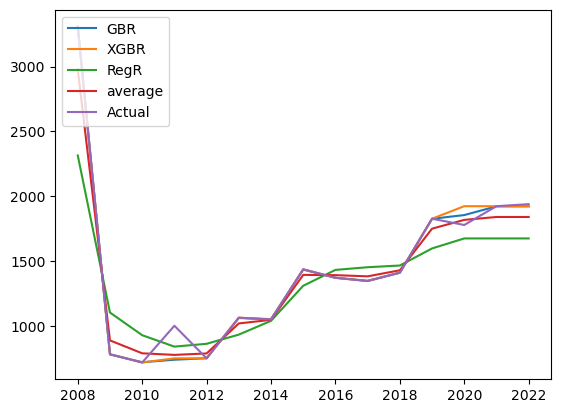

GBR MSE
9137.448235311549
XGBR MSE
14452.54071913863
RegR MSE
19274.326303079502
Average MSE
9958.253836685672


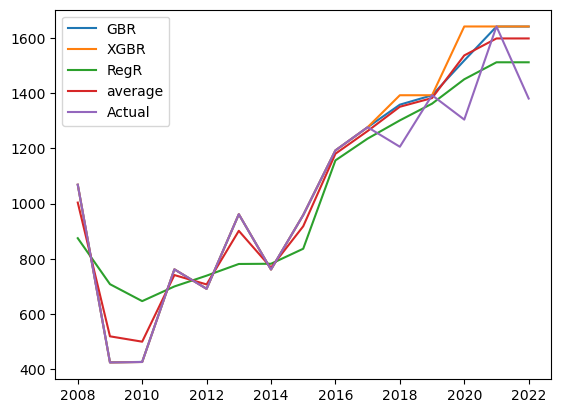

GBR MSE
16647.533165877732
XGBR MSE
6055.750220574061
RegR MSE
17205.94628079084
Average MSE
12147.627535080846


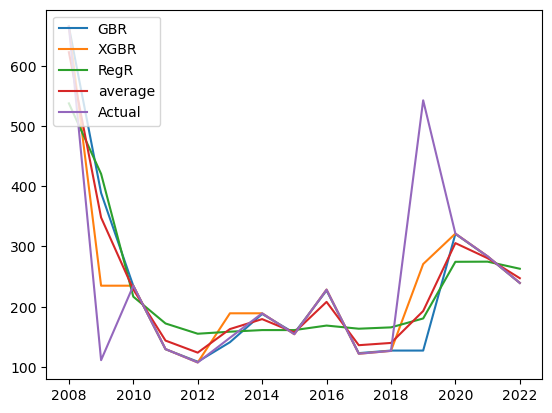

GBR MSE
72.97715497584441
XGBR MSE
73.11649841051805
RegR MSE
72.88898068707005
Average MSE
71.72004099310296


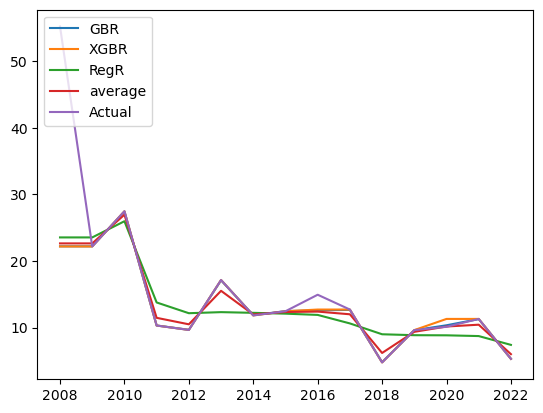

In [16]:
for state in models_gdp:
    test_models(models_gdp[state], totals_gdpfirst[state])
    
plt.show()

GBR MSE
0.00046300308388670875
XGBR MSE
0.0004177806583634781
RegR MSE
0.0014978944976127373
Average MSE
0.0005446779073545905


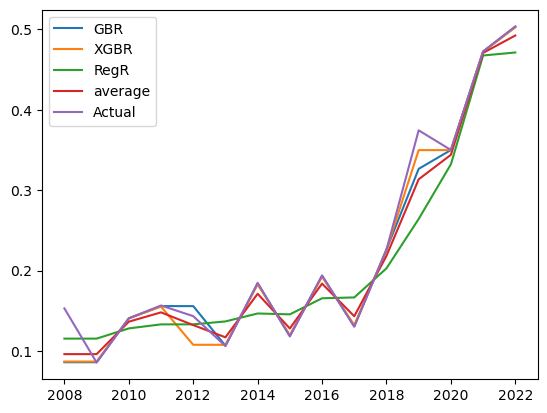

GBR MSE
0.001815058245965385
XGBR MSE
0.0020130606201697156
RegR MSE
0.005069844510259023
Average MSE
0.002156636457822116


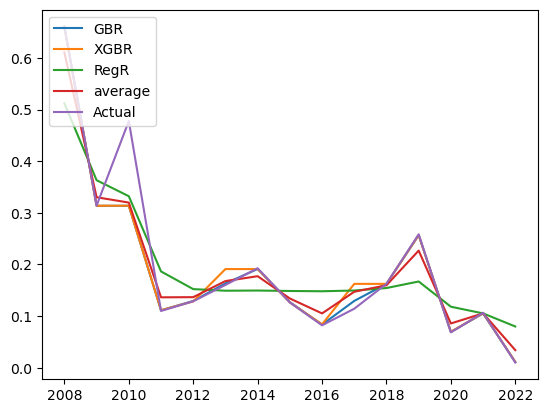

GBR MSE
0.00199485305399754
XGBR MSE
0.0020103567681732273
RegR MSE
0.0036957437381277386
Average MSE
0.0024163224645313637


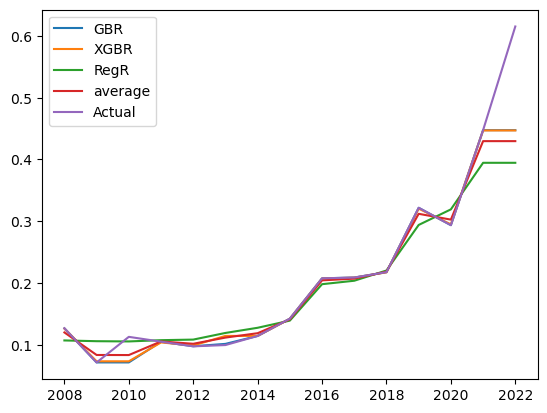

GBR MSE
0.0006556145741864805
XGBR MSE
0.0006184976443310553
RegR MSE
0.0022054391046880647
Average MSE
0.0007991664483675804


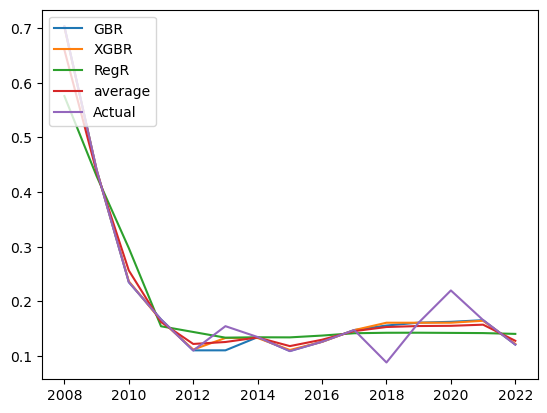

GBR MSE
0.00028015082247462156
XGBR MSE
0.0002627243335297533
RegR MSE
0.0021959858354876
Average MSE
0.00043680105982885374


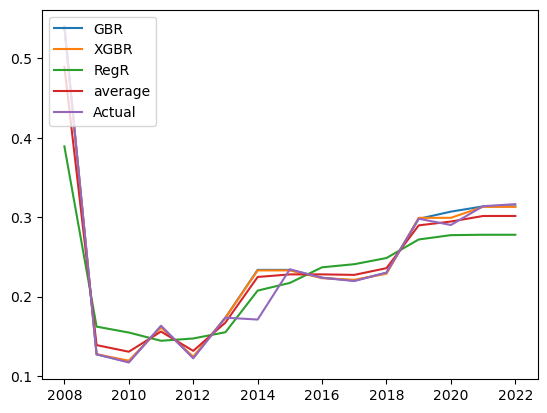

GBR MSE
0.0007970216957948439
XGBR MSE
0.0006646129529138203
RegR MSE
0.0012839931047900035
Average MSE
0.0007877282705341985


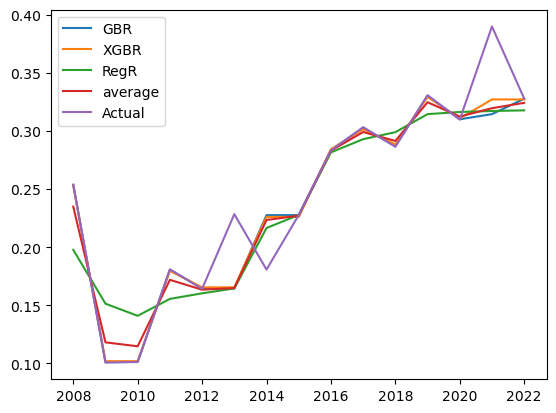

GBR MSE
0.0012996271955597316
XGBR MSE
0.0008891527177755165
RegR MSE
0.006908188452457221
Average MSE
0.0019784277827925643


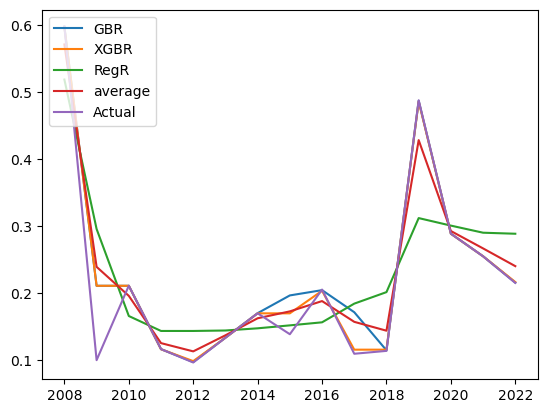

GBR MSE
0.0012278732416885828
XGBR MSE
0.001014583421910409
RegR MSE
0.004805841966595912
Average MSE
0.0016319433384943242


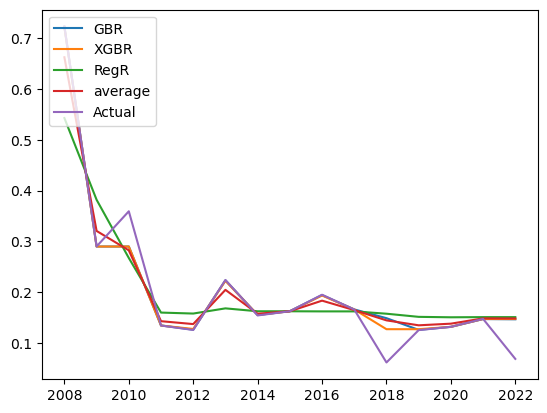

In [17]:
for state in models_gdp:
    test_models(models_gdpnorm[state], totals_gdpfirst_norm[state])
    
plt.show()

# Time-Series Work

In [18]:
file_name_2 = 'brazil_deforestration_by_state_formatted.csv'
data=pd.read_csv(file_name_2)

#Remove geocode_ibge columns
data = data.drop(columns=['geocode_ibge'])
data.sort_values(by=['year'])
year=data['year'].values

In [19]:
state= input('State: ')
state_data=data[data['state']==state]
state_data.sort_values(by=['year'])

State: Acre


,Unnamed: 0,index,year,areakm,municipality,deforestation_increment(areakm),state,gdp,gdp_per_capita
0,0,0,2008,1029.568595,Acrelandia,23.667087,Acre,8.851213e+04,7384.010000
30,30,32,2008,1215.813209,Brasileia,12.663383,Acre,1.353156e+05,6824.130000
240,240,256,2008,414.614587,Rodrigues Alves,4.895515,Acre,6.517543e+04,5005.790000
225,225,240,2008,2409.073841,Rio Branco,28.853650,Acre,3.988385e+06,13232.950000
45,45,48,2008,1132.728016,Bujari,15.772080,Acre,5.887589e+04,8728.820000
...,...,...,...,...,...,...,...,...,...
239,239,254,2022,3062.655247,Rio Branco,118.248798,Acre,1.078470e+07,25842.910989
254,254,270,2022,527.223835,Rodrigues Alves,23.279072,Acre,2.367292e+05,12150.922527
269,269,286,2022,114.865099,Santa Rosa do Purus,3.556363,Acre,9.248420e+04,13488.632308
299,299,318,2022,1744.081345,Senador Guiomard,16.865520,Acre,4.412970e+05,19271.016593


In [20]:
average_km = state_data.groupby('year')['areakm'].mean()

average_km = average_km.to_frame()
average_km=average_km.reset_index()
average_km

,year,areakm
0,2008,895.565653
1,2009,902.917072
2,2010,914.974482
3,2011,928.408634
4,2012,940.704718
5,2013,949.806710
6,2014,965.651654
7,2015,975.781423
8,2016,992.425323
9,2017,1003.591394


### Arima

In [21]:
state_data

,Unnamed: 0,index,year,areakm,municipality,deforestation_increment(areakm),state,gdp,gdp_per_capita
0,0,0,2008,1029.568595,Acrelandia,23.667087,Acre,88512.133000,7384.010000
1,1,1,2009,1042.506828,Acrelandia,12.938233,Acre,94179.964000,7693.810000
2,2,2,2010,1053.838906,Acrelandia,11.332078,Acre,121914.728000,9723.620000
3,3,3,2011,1069.777544,Acrelandia,15.938638,Acre,142760.793000,11171.520000
4,4,4,2012,1073.942261,Acrelandia,4.164718,Acre,162198.825000,12466.280000
...,...,...,...,...,...,...,...,...,...
325,325,346,2018,1392.286143,Xapuri,22.190534,Acre,250235.401000,13137.100000
326,326,347,2019,1452.190898,Xapuri,59.904755,Acre,274589.036000,14210.480000
327,327,348,2020,1491.674935,Xapuri,39.484036,Acre,292045.304000,14903.310000
328,328,349,2021,1550.286681,Xapuri,58.611747,Acre,306408.457385,15861.438462


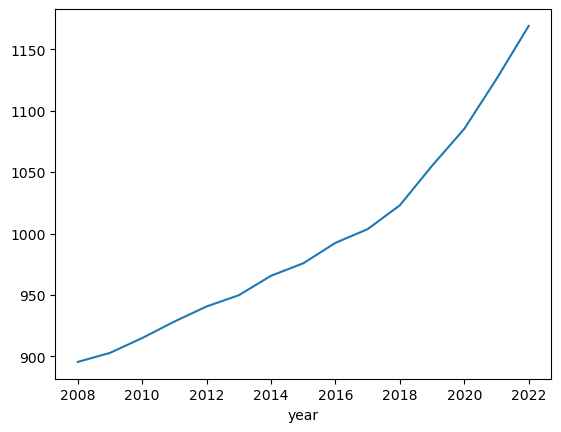

In [22]:
series = state_data.groupby('year')['areakm'].mean()
# Create a Series with a DatetimeIndex
data = pd.Series([1, 2, 3], index=pd.date_range('2022-01-01', periods=3, freq='D'))
#plot the mean area for each year 
series.plot()
plt.show()

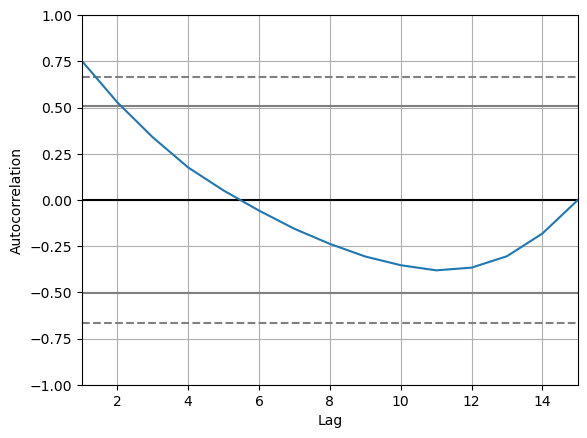

In [23]:
#autocorrelation plot
pd.plotting.autocorrelation_plot(series)
plt.show()

### Linear Model

In [24]:
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values
model = LinearRegression()
model.fit(X, y)

LinearRegression()

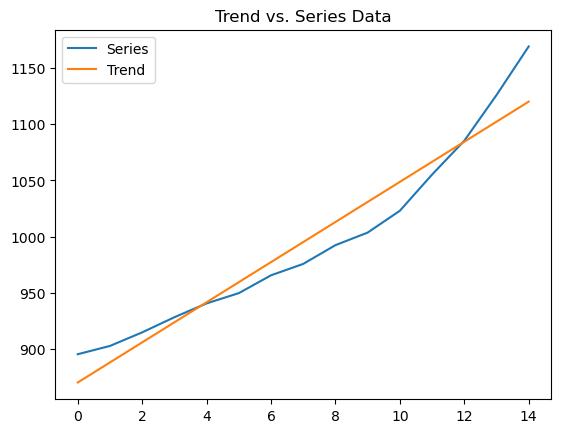

In [25]:
# calculate trend
trend = model.predict(X)
# plot trend vs the series data
plt.plot(y, label='Series')
plt.plot(trend, label = 'Trend')
plt.legend(loc="upper left")
plt.title('Trend vs. Series Data')
plt.show()

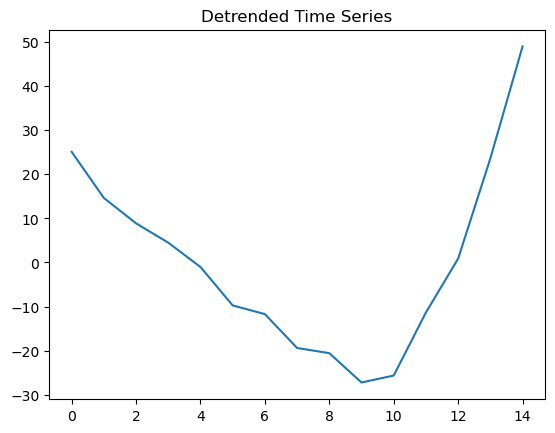

In [26]:
# detrend the time series data by sybtracting the original data by the time series data
detrended = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
plt.plot(detrended)
plt.title('Detrended Time Series')
plt.show()

In [27]:
# Create a polynomial features object
poly = PolynomialFeatures(degree=2)

# Transform the independent variables in the training set
X_poly = poly.fit_transform(X)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_poly, y)

trend = model.predict(X_poly)

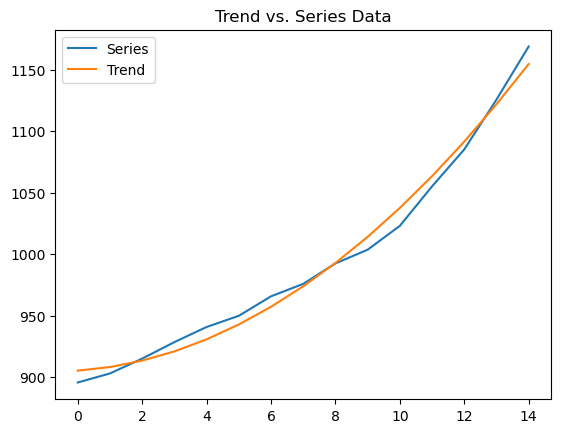

In [28]:
# plot trend vs the series data
plt.plot(y, label='Series')
plt.plot(trend, label = 'Trend')
plt.legend(loc="upper left")
plt.title('Trend vs. Series Data')
plt.show()

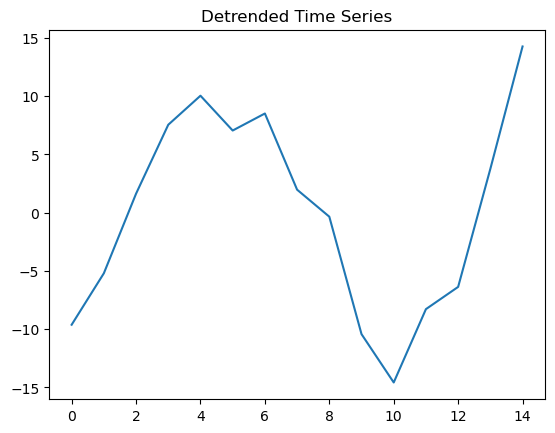

In [29]:
y = series.values
# detrend the time series data by sybtracting the original data by the time series data
detrended = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
plt.plot(detrended)
plt.title('Detrended Time Series')
plt.show()

In [30]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

predictions = list()
#test=scaler.inverse_transform(test.reshape(-1, 1)) #inverse transform
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1)) # model parameters could be further tuned
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    #testing=scaler.inverse_transform(test.reshape(-1, 1)) #inverse transform
    obs = float(test[t])
    history.append(obs)

    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1015.514076, expected=1022.981667
predicted=1037.320807, expected=1055.112554
predicted=1082.463688, expected=1085.145100
predicted=1114.076542, expected=1125.693047
predicted=1163.716120, expected=1168.907323


C:\Users\bakug\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bakug\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [31]:
rmse = sqrt(mse(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10.406


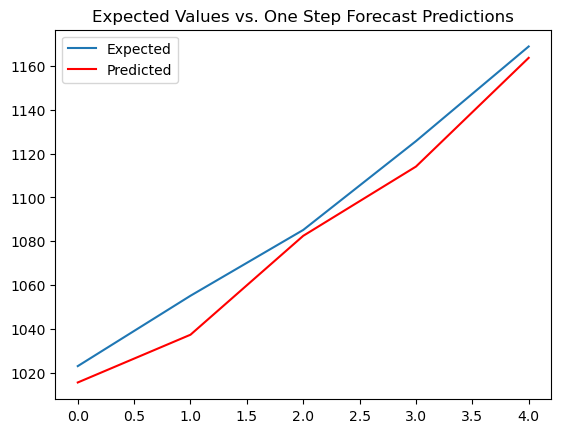

In [32]:
# plot forecasts against actual outcomes
plt.plot(test, label='Expected')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Expected Values vs. One Step Forecast Predictions')
plt.legend(loc="upper left")
plt.show()

### Rolling Forecast

In [33]:
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts

C:\Users\bakug\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bakug\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1018.415194, expected=1022.981667
predicted=1034.028512, expected=1055.112554


C:\Users\bakug\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1081.634356, expected=1085.145100
predicted=1119.640092, expected=1125.693047
predicted=1158.917228, expected=1168.907323


C:\Users\bakug\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
rmse = sqrt(mse(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.083


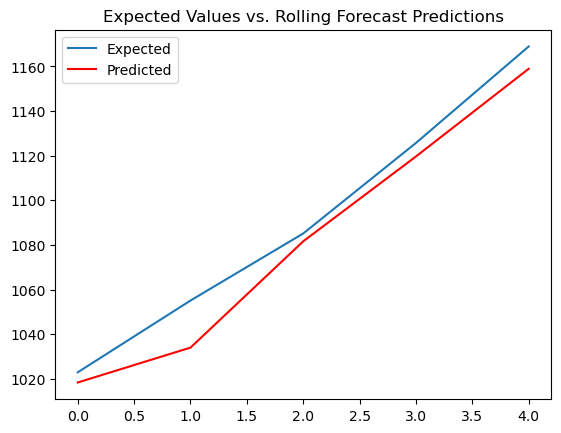

In [35]:
# plot forecasts against actual outcomes
plt.plot(test, label='Expected')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Expected Values vs. Rolling Forecast Predictions')
plt.legend(loc="upper left")
plt.show()

### Series to Supervised 

In [36]:
data = pd.read_csv('./brazil_deforestration_by_state_formatted.csv', usecols =['year','areakm'],header=0, index_col=0)
data_select = data[['areakm']]
values= data_select.values

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [37]:
data1 = series_to_supervised(values, 10)
data1

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
10,1029.568595,1042.506828,1053.838906,1069.777544,1073.942261,1083.417818,1102.314590,1117.076392,1140.882083,1146.592988,1168.377410
11,1042.506828,1053.838906,1069.777544,1073.942261,1083.417818,1102.314590,1117.076392,1140.882083,1146.592988,1168.377410,1188.265357
12,1053.838906,1069.777544,1073.942261,1083.417818,1102.314590,1117.076392,1140.882083,1146.592988,1168.377410,1188.265357,1201.202913
13,1069.777544,1073.942261,1083.417818,1102.314590,1117.076392,1140.882083,1146.592988,1168.377410,1188.265357,1201.202913,1239.468225
14,1073.942261,1083.417818,1102.314590,1117.076392,1140.882083,1146.592988,1168.377410,1188.265357,1201.202913,1239.468225,1257.970850
...,...,...,...,...,...,...,...,...,...,...,...
6220,976.609230,979.732069,986.183050,987.769255,989.149892,989.332244,993.072391,994.612332,996.586170,997.142843,997.643439
6221,979.732069,986.183050,987.769255,989.149892,989.332244,993.072391,994.612332,996.586170,997.142843,997.643439,998.130451
6222,986.183050,987.769255,989.149892,989.332244,993.072391,994.612332,996.586170,997.142843,997.643439,998.130451,998.712631
6223,987.769255,989.149892,989.332244,993.072391,994.612332,996.586170,997.142843,997.643439,998.130451,998.712631,999.774918


In [38]:
#converting the data from part a to a numpy array
values= data1.values
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(values)
print(scaled)

[[0.08516673 0.08623699 0.08717439 ... 0.09437467 0.09484708 0.0966491 ]
 [0.08623699 0.08717439 0.08849284 ... 0.09484708 0.0966491  0.09829425]
 [0.08717439 0.08849284 0.08883735 ... 0.0966491  0.09829425 0.09936446]
 ...
 [0.08157784 0.08170905 0.08182326 ... 0.08252585 0.08256614 0.0826143 ]
 [0.08170905 0.08182326 0.08183835 ... 0.08256614 0.0826143  0.08270217]
 [0.08182326 0.08183835 0.08214773 ... 0.0826143  0.08270217 0.08280716]]


In [39]:
X = scaled[:,:-1]
y = scaled[:,-1]
df= pd.DataFrame(X)
m = int(np.size(X[:, 1]))
bias_vector = np.ones((m, 1))
X = np.append(bias_vector, X, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [40]:
def normalEquation(X, y):

    # Normal Equation:
    # w = inv(X^T * X) * X^T * y

    # For convenience I create a new, tranposed X matrix
    X_transpose = np.transpose(X)

    # Calculating theta
    w = np.linalg.inv(X_transpose.dot(X))
    w = w.dot(X_transpose)
    w = w.dot(y)

    return w

In [41]:
#find the coefficients w
w = normalEquation(X, y)

print("Coefficients:", w)

Coefficients: [ 5.60497460e-03 -2.89888990e-02  1.44868660e-03  1.96833571e-03
 -1.75516229e-04 -3.66646219e-04  3.27499250e-03 -2.40886068e-03
  5.74142748e-03  1.05487128e-03  9.55580597e-01]


In [42]:
def linreg(coef_norm, X_test):
    Y_prediction_norm = X_test.dot(coef_norm)
    return Y_prediction_norm

y_pred = linreg(w, X_test)
print(y_pred)

[0.0568992  0.08172707 0.00280944 ... 0.01529537 0.20574869 0.10785118]


In [43]:
#Mean squared error 

mse = mse(y_test, y_pred)
print("MSE:", mse)

MSE: 0.0009188491969756632


In [44]:
rmse =np.sqrt(mse)
print("RMSE:",rmse)

RMSE: 0.030312525414020904


In [45]:
#R-squared

r2=r2_score(y_test, y_pred)
print("R-Squared:", r2)

R-Squared: 0.9057691628288431


In [46]:
def predict(X_test, coef):
    Y_prediction_sgd = X_test.dot(coef)
    return Y_prediction_sgd

def coefficients_sgd(X_train, Y_train, l_rate, n_epoch): #l-rate is learning rate
  #initializing all coefficients to zero
  coef = [0.0 for i in range(len(X_train[0]))]
  for epoch in range(n_epoch):
    sum_error = 0 # loss
    for i in range(X_train.shape[0]):
      # calculating the prediction using current coeeficients
      yhat = predict(X_train[i,:], coef)
      # calculating error
      error = yhat - Y_train[i] #yhat is prediction, Y_train is ground truth,
      sum_error += error**2 # error square, because loss cannot be negative, or we want to error to be positive.
      #stochastic gradient descent
      coef[0] = coef[0] - l_rate * error
      for j in range(len(coef)-1):
        coef[j + 1] = coef[j + 1] - l_rate * error * X_train[i,j]
    
    print( ' >epoch=%d, lrate=%.3f, error=%.3f ' % (epoch, l_rate, sum_error))
  #returning the list of coefficients  
  return coef

In [47]:
l_rate = 0.01
n_epoch = 200

coef = coefficients_sgd(X_train, y_train, l_rate, n_epoch)

 >epoch=0, lrate=0.010, error=17.692 
 >epoch=1, lrate=0.010, error=10.233 
 >epoch=2, lrate=0.010, error=8.639 
 >epoch=3, lrate=0.010, error=7.739 
 >epoch=4, lrate=0.010, error=7.184 
 >epoch=5, lrate=0.010, error=6.823 
 >epoch=6, lrate=0.010, error=6.574 
 >epoch=7, lrate=0.010, error=6.391 
 >epoch=8, lrate=0.010, error=6.250 
 >epoch=9, lrate=0.010, error=6.136 
 >epoch=10, lrate=0.010, error=6.041 
 >epoch=11, lrate=0.010, error=5.959 
 >epoch=12, lrate=0.010, error=5.886 
 >epoch=13, lrate=0.010, error=5.821 
 >epoch=14, lrate=0.010, error=5.762 
 >epoch=15, lrate=0.010, error=5.709 
 >epoch=16, lrate=0.010, error=5.659 
 >epoch=17, lrate=0.010, error=5.614 
 >epoch=18, lrate=0.010, error=5.571 
 >epoch=19, lrate=0.010, error=5.532 
 >epoch=20, lrate=0.010, error=5.495 
 >epoch=21, lrate=0.010, error=5.461 
 >epoch=22, lrate=0.010, error=5.429 
 >epoch=23, lrate=0.010, error=5.399 
 >epoch=24, lrate=0.010, error=5.370 
 >epoch=25, lrate=0.010, error=5.344 
 >epoch=26, lrate=0.

In [48]:
print(coef)
np.shape(coef)

[0.0031749236230501727, 0.0031749236230501727, -0.15483700549722604, 0.2709233084322598, -0.29636538478037383, 0.1701350028402839, 0.03216373980397877, -0.13626901839474487, 0.14128824189521763, 0.07518525898906178, 0.8018309641406882]


(11,)

In [ ]:
Y_pred = np.array(predict(X_test[0,:], coef))
for i in range(X_test.shape[0]-1):
  Y_pred = np.append(Y_pred, predict(X_test[i+1,:], coef))

mse = mse(y_test, Y_pred)
print("MSE:", mse)

In [50]:
rmse=np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.030312525414020904


In [51]:
r2=r2_score(y_test, Y_pred)
print("R-Squared:", r2)

R-Squared: 0.8900660187867886


### Ensemble Model

In [52]:
import warnings

warnings.filterwarnings("ignore")
data = pd.read_csv("brazil_deforestration_by_state_formatted.csv")

In [53]:
data.year.unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022], dtype=int64)

In [54]:
data.corr()

,Unnamed: 0,index,year,areakm,geocode_ibge,deforestation_increment(areakm),gdp,gdp_per_capita
Unnamed: 0,1.000000,1.000000,2.404278e-03,0.212364,2.174974e-01,-0.003065,-0.036078,0.257144
index,1.000000,1.000000,2.254011e-03,0.212359,2.174975e-01,-0.003077,-0.036087,0.257095
year,0.002404,0.002254,1.000000e+00,0.035486,-7.702218e-14,0.079713,0.057419,0.325906
areakm,0.212364,0.212359,3.548599e-02,1.000000,3.495719e-01,0.523478,0.097106,0.305398
geocode_ibge,0.217497,0.217497,-7.702218e-14,0.349572,1.000000e+00,0.022013,-0.021672,0.453395
deforestation_increment(areakm),-0.003065,-0.003077,7.971260e-02,0.523478,2.201250e-02,1.000000,0.083388,0.075659
gdp,-0.036078,-0.036087,5.741937e-02,0.097106,-2.167226e-02,0.083388,1.000000,0.155684
gdp_per_capita,0.257144,0.257095,3.259056e-01,0.305398,4.533948e-01,0.075659,0.155684,1.000000


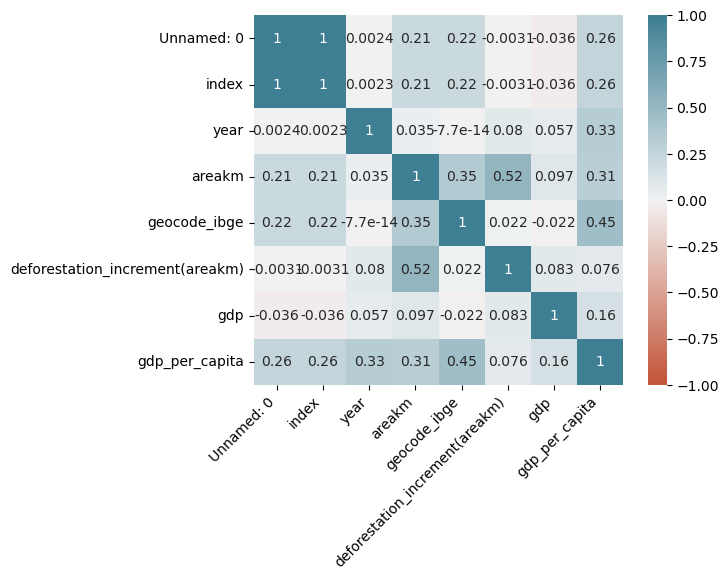

In [55]:
import seaborn as sns
corr = data.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20,220,n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [56]:
data = data.drop(columns=['index','geocode_ibge'])
data = pd.get_dummies(data=data,columns=['state','municipality'])
#Subsetting dataset
data_holdout = data.loc[data['year'].isin([2020,2021,2022])]
data_rest = data.loc[~data['year'].isin([2020,2021,2022])]

# Taking the data related to years except for the later 3 for grid search
data_rest_base = data_rest.loc[~data_rest['year'].isin([2017,2018,2019])]
# Taking the data related to later 3 for ols
data_rest_meta = data_rest.loc[data_rest['year'].isin([2017,2018,2019])]
data_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 12 to 6224
Columns: 426 entries, Unnamed: 0 to municipality_Ze Doca
dtypes: float64(4), int64(2), uint8(420)
memory usage: 578.7 KB


In [57]:
y_test = data_holdout.pop('deforestation_increment(areakm)')
y_meta = data_rest_meta.pop('deforestation_increment(areakm)')
x_meta = data_rest_meta

y_base = data_rest_base.pop('deforestation_increment(areakm)')
x_base = data_rest_base
x_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 9 to 6221
Columns: 425 entries, Unnamed: 0 to municipality_Ze Doca
dtypes: float64(3), int64(2), uint8(420)
memory usage: 569.0 KB


In [58]:
x_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3735 entries, 0 to 6218
Columns: 425 entries, Unnamed: 0 to municipality_Ze Doca
dtypes: float64(3), int64(2), uint8(420)
memory usage: 1.7 MB


In [59]:
from sklearn.preprocessing import StandardScaler

#Scale the data
scaler = StandardScaler()
x_base = scaler.fit_transform(x_base)
x_meta = scaler.transform(x_meta)
x_test = scaler.transform(data_holdout)

In [60]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

#Lasso regression model
lasso = Lasso(fit_intercept=1, alpha=0.05, max_iter=10000, random_state=8)

las_params = {'fit_intercept': [1, 0],
              'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]}

#These splits are used to find the best GS hyper-parameters
time_split_inner = TimeSeriesSplit(n_splits = 3)

#Run grid search to find best parameters for lasso regression
gs_las = GridSearchCV(lasso, las_params, cv=time_split_inner, scoring='neg_mean_squared_error')
gs_las.fit(x_base, y_base)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Lasso(alpha=0.05, fit_intercept=1, max_iter=10000,
                             random_state=8),
             param_grid={'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1],
                         'fit_intercept': [1, 0]},
             scoring='neg_mean_squared_error')

In [61]:
from sklearn.neural_network import MLPRegressor

#Multi-Layer Perceptron
mlp = MLPRegressor(early_stopping=True, max_iter=1000, random_state=8)

mlp_params = {'hidden_layer_sizes': [(24,), (36,), (24,24), (24,12), (36,24), (36,12)], 
              'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
              'activation': ['relu', 'identity', 'tanh']}

#Run grid search to find best parameters for MLP regressor
gs_mlp = GridSearchCV(mlp, mlp_params, cv=time_split_inner, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_mlp.fit(x_base, y_base)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=MLPRegressor(early_stopping=True, max_iter=1000,
                                    random_state=8),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [(24,), (36,), (24, 24),
                                                (24, 12), (36, 24), (36, 12)]},
             scoring='neg_mean_squared_error', verbose=1)

In [62]:
from sklearn.svm import LinearSVR

#Linear Support Vector Regression
svr = LinearSVR(loss='squared_epsilon_insensitive', max_iter=1000, random_state=8)

svr_params = {'epsilon': [8, 9, 10, 11, 12, 13, 14],
              'fit_intercept': [0, 1],
              'C': [33, 34, 35, 36, 37, 38, 39, 40, 41]}

#Run grid search to find best parameters for LinearSVR
gs_svr = GridSearchCV(svr, svr_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_svr.fit(x_base, y_base)              

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearSVR(loss='squared_epsilon_insensitive',
                                 random_state=8),
             n_jobs=-1,
             param_grid={'C': [33, 34, 35, 36, 37, 38, 39, 40, 41],
                         'epsilon': [8, 9, 10, 11, 12, 13, 14],
                         'fit_intercept': [0, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [63]:
from sklearn.svm import SVR

# Support Vector Machine
svm = SVR(C=0.1, max_iter=1000)

svm_params = {'kernel': ['rbf', 'sigmoid', 'poly'],
              'gamma': ['scale', 'auto', 0.2], 
              'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]}

#Run grid search to find best parameters for SVR
gs_svm = GridSearchCV(svm, svm_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_svm.fit(x_base, y_base)              

Fitting 3 folds for each of 63 candidates, totalling 189 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=SVR(C=0.1, max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': ['scale', 'auto', 0.2],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

In [64]:
from sklearn.ensemble import RandomForestRegressor

#Random Forest Regressor
rf = RandomForestRegressor(random_state=8)

rf_params = {'n_estimators': range(300, 500, 25),
             'min_samples_split': [2, 3, 4, 5, 6, 7],
             'max_features': ['log2', 'sqrt']}

#Run grid search to find best parameters for RandomForest Regressor
gs_rf = GridSearchCV(rf, rf_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_rf.fit(x_base, y_base)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=8), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': range(300, 500, 25)},
             scoring='neg_mean_squared_error', verbose=1)

In [65]:
gs_las.best_params_

{'alpha': 0.1, 'fit_intercept': 1}

In [66]:
gs_mlp.best_params_

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (24, 12)}

In [67]:
gs_svr.best_params_

{'C': 33, 'epsilon': 14, 'fit_intercept': 0}

In [68]:
gs_svm.best_params_

{'C': 0.2, 'gamma': 0.2, 'kernel': 'sigmoid'}

In [69]:
gs_rf.best_params_

{'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}

In [70]:
est_meta = pd.DataFrame(y_meta)

In [71]:
# The predictions of the base models on the meta-training set, which will be used to train the meta model
est_meta['lasso'] = gs_las.predict(x_meta)
est_meta['mlp'] = gs_mlp.predict(x_meta)
est_meta['svr'] = gs_svr.predict(x_meta)
est_meta['svm'] = gs_svm.predict(x_meta)
est_meta['random_forest'] = gs_rf.predict(x_meta)

In [72]:
y_meta = est_meta.pop('deforestation_increment(areakm)')

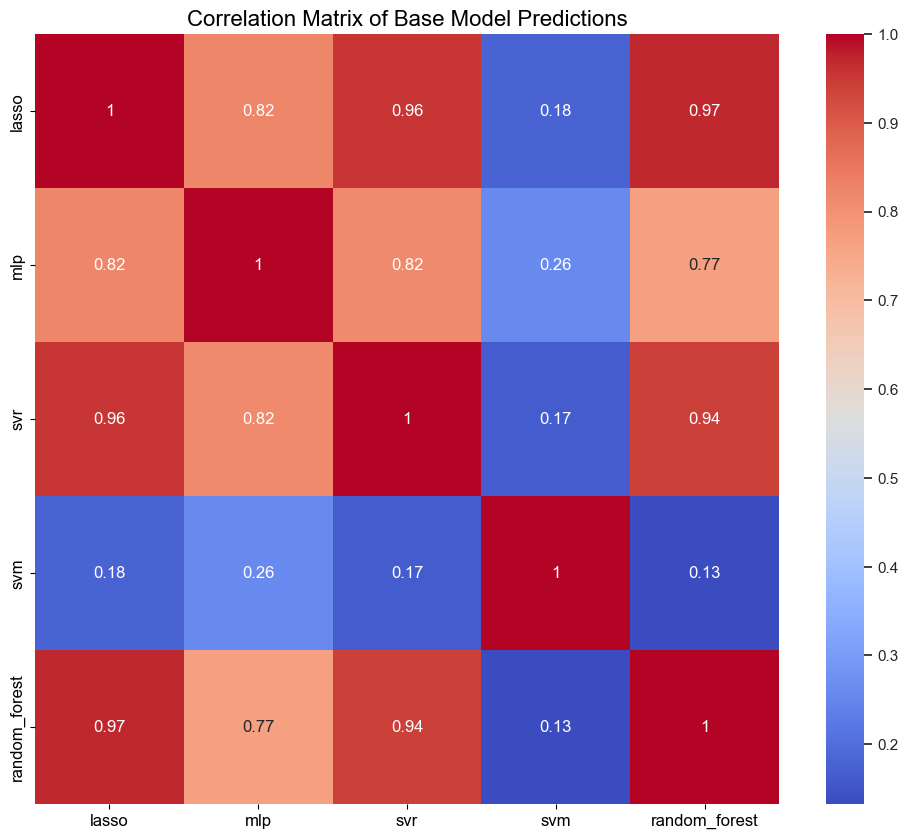

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.set(font_scale=1.0)
sns.heatmap(est_meta.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Base Model Predictions", fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
plt.show()

In [74]:
from sklearn.linear_model import LinearRegression

# Setting Linear Regression as the final stage meta model
meta = LinearRegression()
# Fitting the meta model to the predictions of the base models on the meta-training set, and y_meta
meta.fit(est_meta, y_meta)

LinearRegression()

In [75]:
y_test

12      12.937556
13      38.265312
14      18.502625
27      18.174810
28      17.649864
          ...    
6208     1.941244
6209     0.000000
6222     0.582180
6223     1.062286
6224     1.269176
Name: deforestation_increment(areakm), Length: 1245, dtype: float64

In [76]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

def reg_scoring(x, y, meta, reg_dict):  
    mae_scores = []
    mse_scores = []
    
    df_pred = pd.DataFrame(columns=reg_dict.keys()) # Columns of DF will accord with reg_dict keys
    
    # Loop through Dictionary items
    for key, reg in reg_dict.items():
        pred_y = reg.predict(x)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        # Computing test scores for each model
        mae_scores.append(round(mean_absolute_error(y, pred_y), 4))
        mse_scores.append(round(mean_squared_error(y, pred_y, squared=False), 4))
        
    # Generate results DataFrame
    results = pd.DataFrame({'Model': list(reg_dict.keys()), 
                            'Mean Absolute Error': mae_scores,
                            'Root Mean Squared Error': mse_scores
                            })
    
    # Generate Stack Model's predictions, and test scores
    df_pred['Stack Model'] = meta.predict(df_pred)

    s1 = round(mean_absolute_error(y, df_pred['Stack Model']), 4)
    s2 = round(mean_squared_error(y, df_pred['Stack Model'], squared=False), 4)
    
    
    # Add deforestation_increment(areakm) variable to the DataFrame of predictions
    df_pred['deforestation_increment(areakm)'] = y.tolist()
        
        
    # Inserting the Stack scores to the results DataFrame
    row1 = ['Stack Model', s1, s2]
    results.loc[len(results)] = row1
    
    return results, df_pred

In [77]:
# Dictionary of TRAINED base models
reg_dict = {
    'lasso': gs_las,
    'mlp': gs_mlp, 
    'svr': gs_svr,
    'svm': gs_svm,
    'random_forest': gs_rf
}

In [78]:
scores, data_pred = reg_scoring(x_test, y_test, meta, reg_dict)

In [79]:
data_pred['deforestation_increment(areakm)']

0       12.937556
1       38.265312
2       18.502625
3       18.174810
4       17.649864
          ...    
1240     1.941244
1241     0.000000
1242     0.582180
1243     1.062286
1244     1.269176
Name: deforestation_increment(areakm), Length: 1245, dtype: float64

In [80]:
scores

,Model,Mean Absolute Error,Root Mean Squared Error
0,lasso,11.0622,40.4504
1,mlp,11.9366,48.3197
2,svr,22.1934,29.6776
3,svm,20.6508,56.2105
4,random_forest,10.4199,38.2980
5,Stack Model,8.8413,27.5625


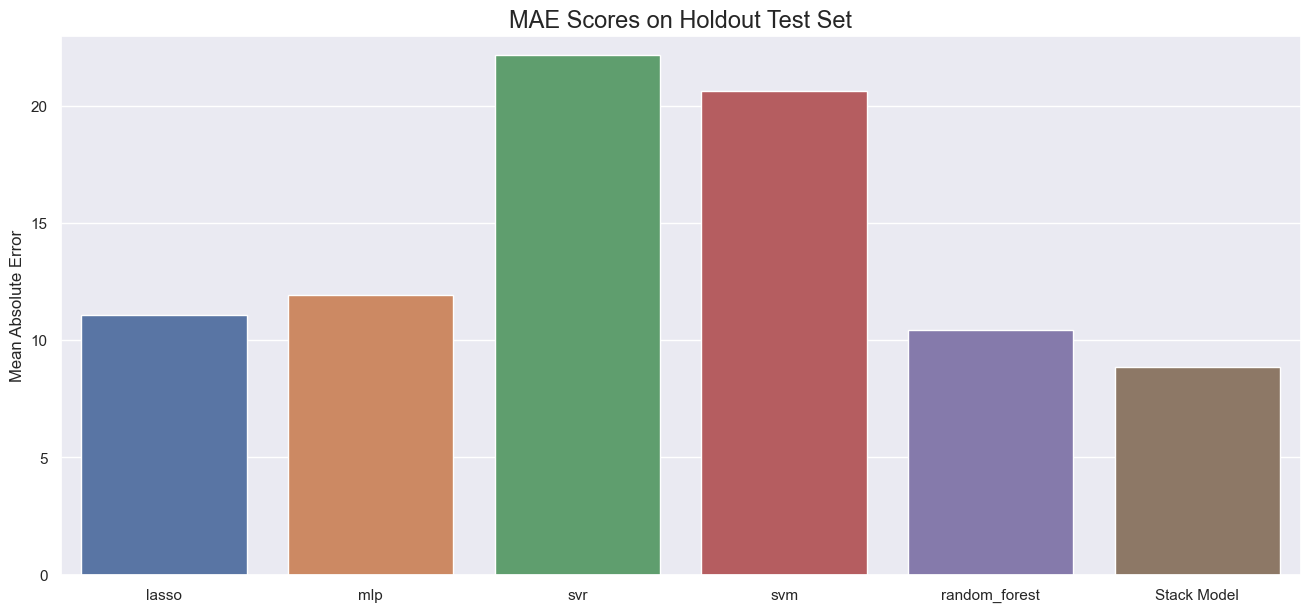

In [81]:
fig, ax = plt.subplots(figsize=(16,7))

sns.barplot(x='Model', y='Mean Absolute Error', data=scores, ax=ax)
ax.set(ylim=(0, 23))

ax.set_ylabel('Mean Absolute Error', size=12)
ax.set_xlabel('')
plt.title('MAE Scores on Holdout Test Set', fontsize=17);

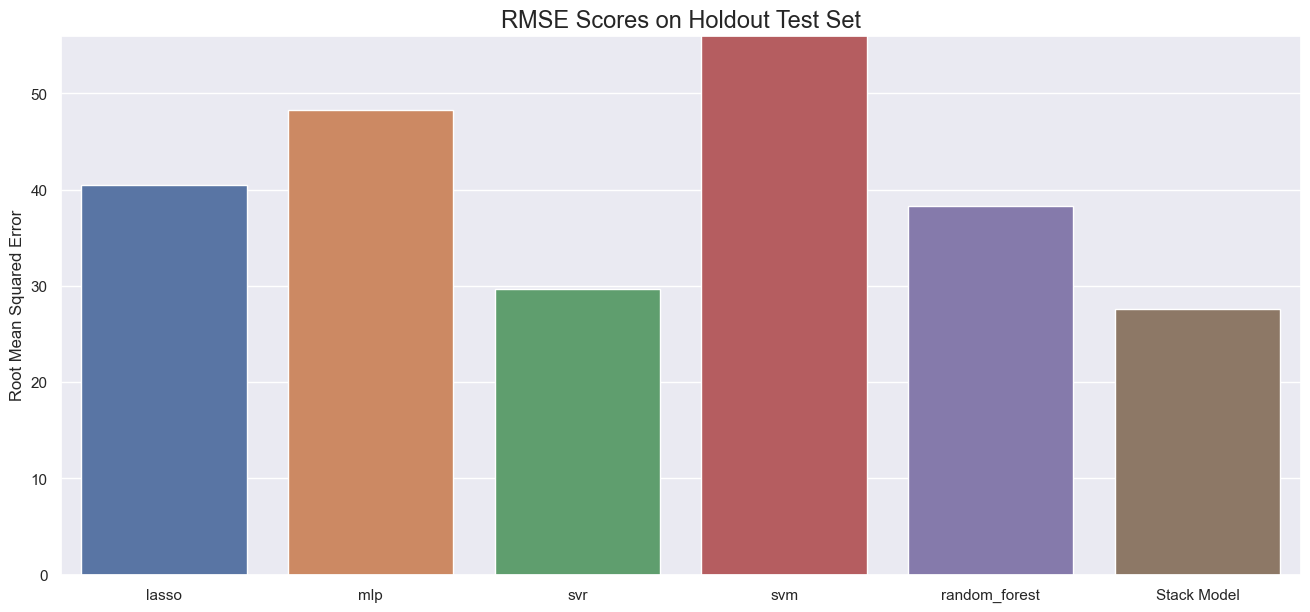

In [82]:
fig, ax = plt.subplots(figsize=(16,7))

sns.barplot(x='Model', y='Root Mean Squared Error', data=scores, ax=ax)
ax.set(ylim=(0, 56))

ax.set_ylabel('Root Mean Squared Error', size=12)
ax.set_xlabel('')
plt.title('RMSE Scores on Holdout Test Set', fontsize=17);

In [83]:
data_pred.index = data_holdout.index

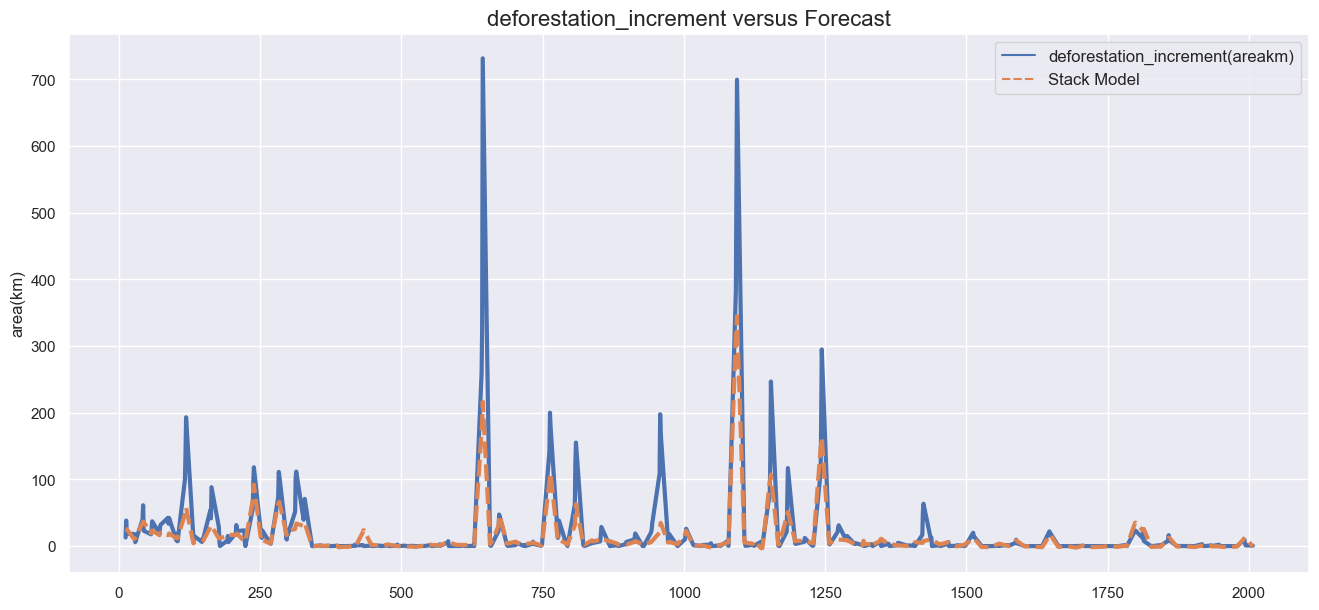

In [84]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=data_pred[['deforestation_increment(areakm)', 'Stack Model']], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('deforestation_increment versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('area(km)', fontsize=12);